# Group 2 Capstone Project
####*Classification of Brain Tumour Subtypes Using Multilayer Perceptrons on Gene Expression Data*
---
Participants:
<pre>
Name                         Student Number
*   Arman Torabi (Team lead) (1058001)
*   Gerrit van Aalst         (1035187)
*   Jesse de Zeeuw           (1058515)
*   Martijn Warnas           (1048740)
*   Thom Veldhuis            (1055805)
</pre>

<quote>Grote stappen zet je doormiddel van kleine</quote>

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn requests HTSeq pip shap

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.simplefilter(action='always', category=UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

# Loading dataset

In [ ]:
# Load dataset
# info: https://sbcb.inf.ufrgs.br/cumida
datasets = [
  "https://sbcb.inf.ufrgs.br/data/cumida/Genes/Brain/GSE50161/Brain_GSE50161.csv",
  "https://sbcb.inf.ufrgs.br/data/cumida/Genes/Brain/GSE15824/Brain_GSE15824.csv",
]
li = []

# It are two different datasets to use, these need to be combined
for filename in datasets:
    frame = pd.read_csv(filename, index_col=None, header=0)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df.head(10)

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,834,ependymoma,12.498150,7.604868,6.880934,9.027128,4.176175,7.224920,6.085942,6.835999,...,9.979005,9.926470,12.719785,12.777792,5.403657,4.870548,4.047380,3.721936,4.516434,4.749940
1,835,ependymoma,13.067436,7.998090,7.209076,9.723322,4.826126,7.539381,6.250962,8.012549,...,11.924749,11.215930,13.605662,13.401342,5.224555,4.895315,3.786437,3.564481,4.430891,4.491416
2,836,ependymoma,13.068179,8.573674,8.647684,9.613002,4.396581,7.813101,6.007746,7.178156,...,12.154405,11.532460,13.764593,13.477800,5.303565,5.052184,4.005343,3.595382,4.563494,4.668827
3,837,ependymoma,12.456040,9.098977,6.628784,8.517677,4.154847,8.361843,6.596064,6.347285,...,11.969072,11.288801,13.600828,13.379029,4.953429,4.708371,3.892318,3.759429,4.748381,4.521275
4,838,ependymoma,12.699958,8.800721,11.556188,9.166309,4.165891,7.923826,6.212754,6.866387,...,11.411701,11.169317,13.751442,13.803646,4.892677,4.773806,3.796856,3.577544,4.504385,4.541450
5,839,ependymoma,12.461089,7.676462,7.244519,9.676867,3.904301,7.467139,6.585188,7.061578,...,11.210663,10.808249,13.593281,13.616164,5.201016,4.850920,3.887500,3.596379,4.518055,4.526295
6,840,ependymoma,13.655639,7.980903,7.566620,10.102907,4.659353,8.457659,6.187350,7.533436,...,12.107981,11.560651,13.729656,13.557003,5.508786,5.022758,3.967091,3.735595,4.450776,4.771273
7,841,ependymoma,12.601370,8.873161,9.214310,9.690334,4.341822,7.924622,6.482649,6.499633,...,11.330031,10.967963,13.693713,13.721795,5.254671,4.749096,3.968936,3.548965,4.554688,4.584465
8,842,ependymoma,12.463229,8.206494,8.891218,9.737344,3.936265,7.906298,6.066180,6.980854,...,11.426086,10.983441,13.589301,13.671639,5.227229,4.753435,3.844161,3.661761,4.398036,4.600163
9,843,ependymoma,12.265713,7.879857,10.210694,9.700963,4.087726,8.102050,6.510385,6.986585,...,11.147224,10.764300,13.616102,13.678913,5.245267,4.825813,3.915294,3.743049,4.464424,4.517736


In [ ]:
print("Data Overview:")
print(df.info())
print(df["type"].unique())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Columns: 54677 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(54675), object(2)
memory usage: 69.7+ MB
None
['ependymoma' 'glioblastoma' 'medulloblastoma' 'normal'
 'pilocytic_astrocytoma' 'Glioblastoma' 'Astrocytoma' 'Oligodendrioglioma'
 'glioblastoma-cell-line']


In [ ]:
# this takes very long lol
print("\nSummary Statistics:")
#print(df.describe())


Summary Statistics:


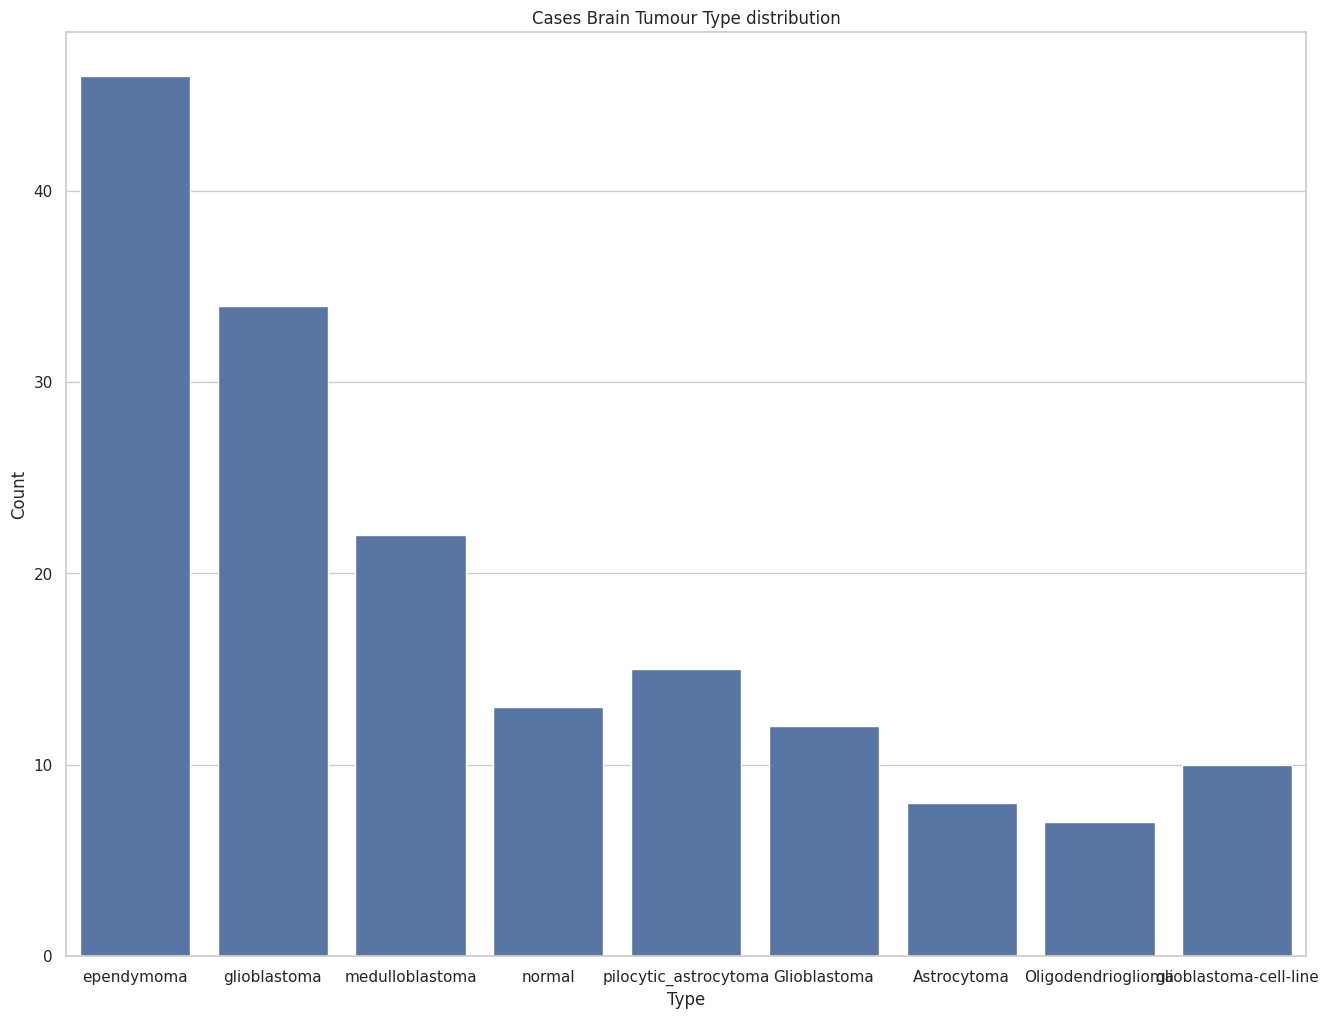

In [ ]:
plt.figure(figsize=(16, 12))
sns.countplot(x='type', data=df)
plt.title('Cases Brain Tumour Type distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

# Data pre-processing.

In [ ]:
# make the types binary instead of more
df['type'] = df['type'].apply(lambda x: 0 if x == 'normal' else 1)
# sample is not needed for training, and such
X = df.drop(columns=['samples', 'type'])
# we want the type as the output of the models
y = df['type']
# for PCA and feature selection
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['type'])
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

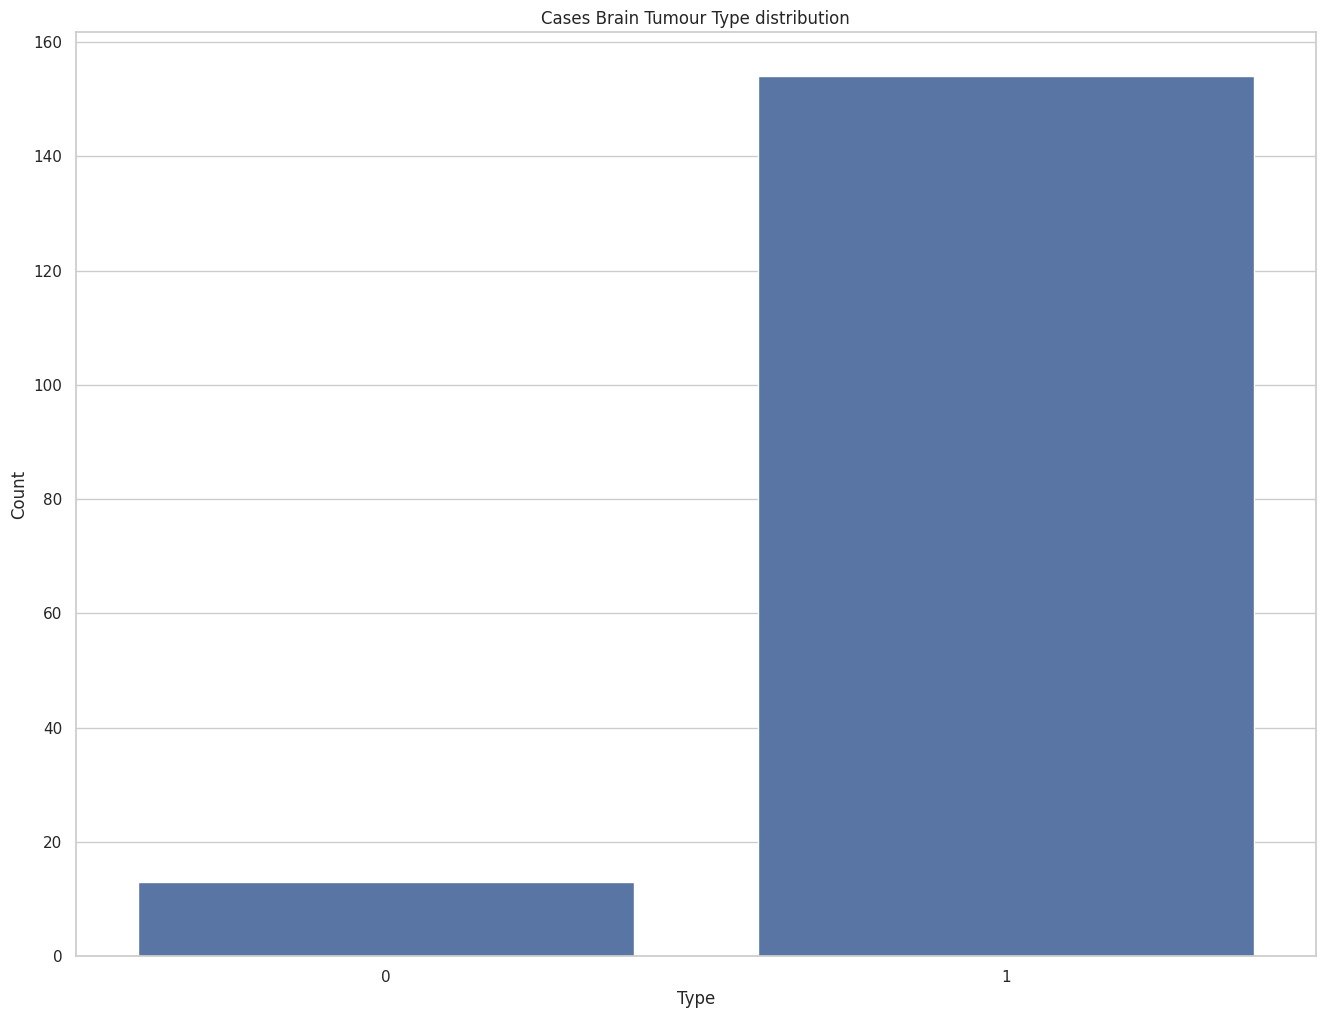

In [ ]:
plt.figure(figsize=(16, 12))
sns.countplot(x='type', data=df)
plt.title('Cases Brain Tumour Type distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

In [ ]:
# Initialize the standard scaler
scaler = StandardScaler()
# Scale the input features
X_scaled = scaler.fit_transform(X)
# Initialize SelectKBest to keep the top k features. The selection is based on
# statistical tests or scoring methods that evaluate the importance of each
# feature with respect to the target variable.
k = 1000
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_scaled, y)
print(X_selected[:5])

[[ 0.61284884  0.8663824   0.09263095 ...  0.62519268 -0.55890714
  -0.4450261 ]
 [ 0.19319275  1.70336843 -0.11121194 ...  0.80185689 -0.81636108
   1.40003621]
 [ 1.2996242  -0.0894214   0.00939    ...  0.09104091  0.12519945
   0.58991424]
 [-0.32023964 -0.11994069  0.01439581 ...  0.02330444  0.03408624
  -0.0258334 ]
 [ 0.53458666  0.06000956  0.09769469 ... -0.50501217  0.20941554
  -0.48583902]]


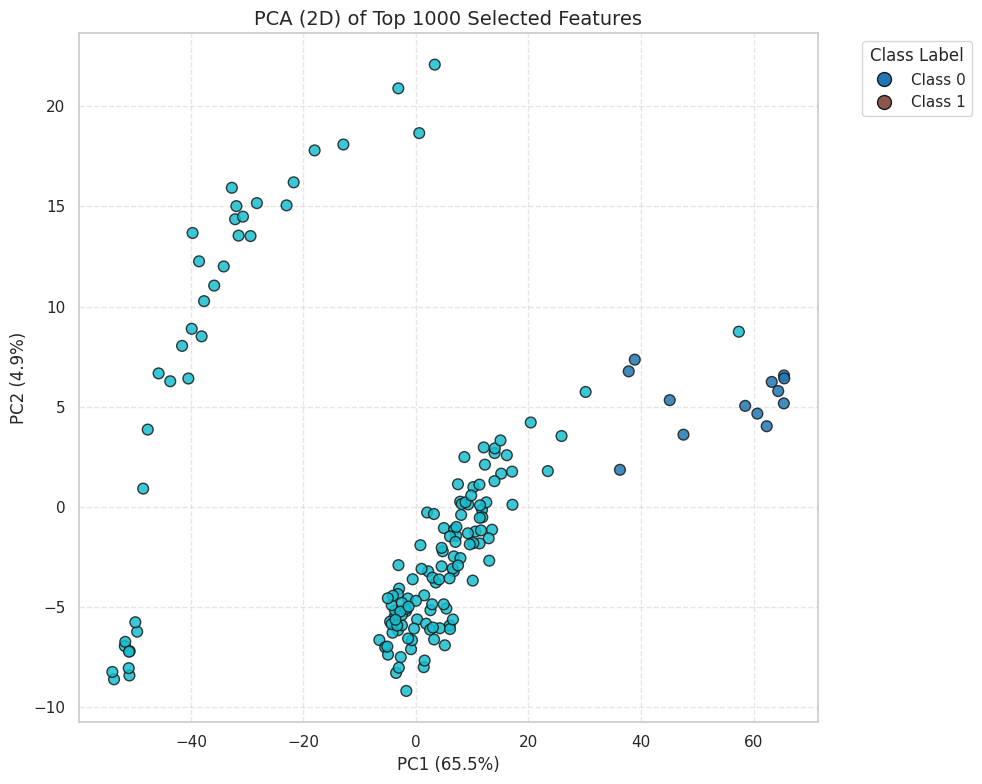

In [ ]:
# Reduce to 2D for visualization
# We can than see patterns in the features hopefully
pca_vis = PCA(n_components=5)
X_vis = pca_vis.fit_transform(X_selected)

sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_vis[:, 0], X_vis[:, 1],
    c=y, cmap='tab10', edgecolor='k', s=60, alpha=0.85
)
plt.xlabel(f"PC1 ({pca_vis.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca_vis.explained_variance_ratio_[1]*100:.1f}%)")
plt.title(f"PCA (2D) of Top {k} Selected Features", fontsize=14)
classes = np.unique(y)
handles = [
    plt.Line2D([], [], marker='o', color='w', label=f"Class {cls}",
               markerfacecolor=plt.cm.tab10(i / len(classes)), markersize=10, markeredgecolor='k')
    for i, cls in enumerate(classes)
]
plt.legend(handles=handles, title="Class Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Splitting data in training and testing

In [ ]:
# traditional way before learning about StratifiedShuffleSplit :)
#X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
#print("Length of the training data:", len(X_train))
#print("Length of the test data:", len(X_test))

# Different splitting based on the features because the output classes are pretty different in count
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in sss.split(X_selected, y):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Training MLP Model


In [ ]:
num_labels = len(np.unique(y_train))
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

input_size = X_train.shape[1]

batch_size = 64
hidden_units = 256
dropout = 0.3

model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(Dense(hidden_units, kernel_regularizer=l2(1e-4)))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units, kernel_regularizer=l2(1e-4)))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,562 (1.23 MB)

 Trainable params: 322,562 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optim = Adam(
    learning_rate=0.0001
)

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('mlp_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
  X_train,
  y_train_categorical,
  validation_split=0.25,
  epochs=50,
  batch_size=batch_size,
  callbacks=[checkpoint, reduce_lr]
)

test_loss, test_acc = model.evaluate(X_test, y_test_categorical, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * test_acc))

predictions = model.predict(X_test)
print("Predicted:", np.argmax(predictions, axis=1))
print("True labels:", np.argmax(y_test_categorical, axis=1))

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.1635 - loss: 1.7114 - val_accuracy: 0.3750 - val_loss: 0.9145 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3231 - loss: 1.3163 - val_accuracy: 0.3438 - val_loss: 0.7653 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.5479 - loss: 0.8169 - val_accuracy: 0.6875 - val_loss: 0.7004 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6189 - loss: 0.7444 - val_accuracy: 0.7500 - val_loss: 0.6475 - learning_rate: 1.0000e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7127 - loss: 0.6218 - val_accuracy: 0.8438 - val_loss: 0.6004 - learning_rate: 1.0000e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8000 - loss: 0.4639 - val_accuracy: 0.8438 - val_loss: 0.5694 - learning_rate: 1.0000e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8085 - loss: 0.5985 

In [ ]:
y_true_labels = np.argmax(y_test_categorical, axis=1)
y_pred_labels = np.argmax(predictions, axis=1)

print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.97      0.97      0.97        39

    accuracy                           0.95        42
   macro avg       0.82      0.82      0.82        42
weighted avg       0.95      0.95      0.95        42



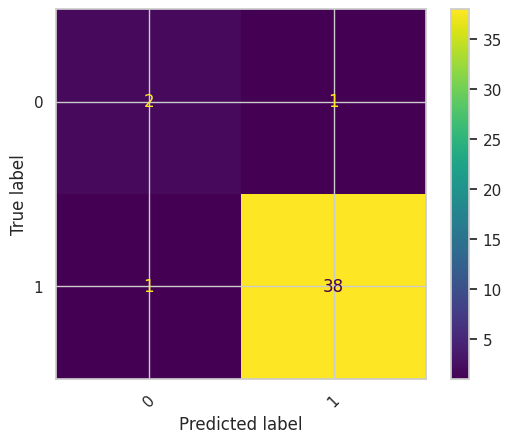

In [ ]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.show()

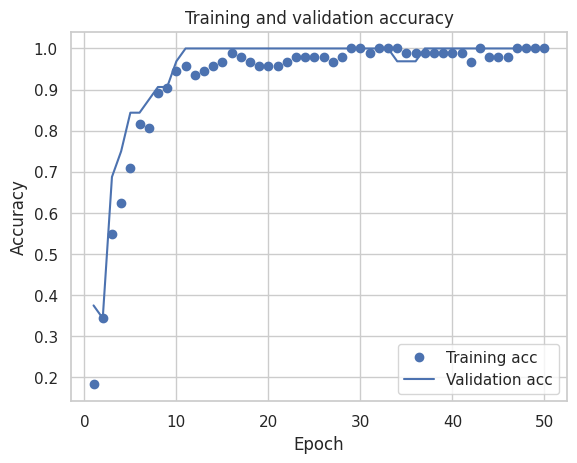

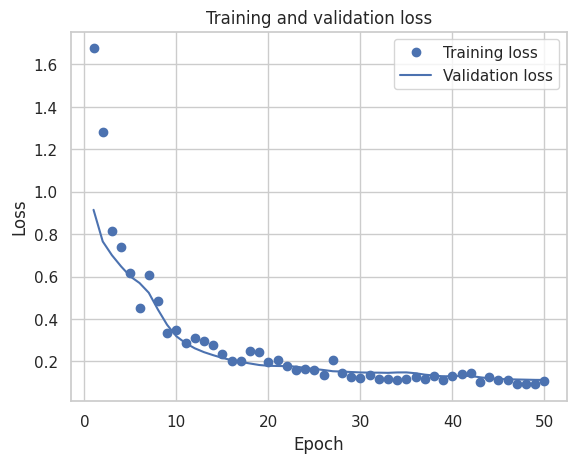

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Training Random Forest Classifier

In [ ]:
# Initialize the model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
# Predict on the test set
y_pred = rf_model.predict(X_test)

In [ ]:
# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9761904761904762

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.97      1.00      0.99        39

    accuracy                           0.98        42
   macro avg       0.99      0.83      0.89        42
weighted avg       0.98      0.98      0.97        42



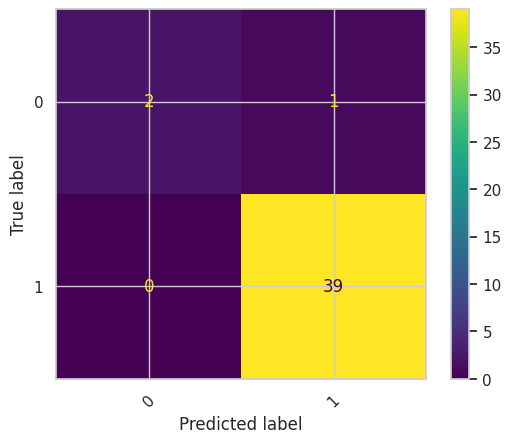

In [ ]:
# Confusion matrix to see class-wise performance
#cm = confusion_matrix(y_test, y_pred)
#plt.figure(figsize=(10, 7))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.title('Confusion Matrix')
#plt.show()

# Confusion Matrix
cm_r = confusion_matrix(y_test, y_pred)
disp_r = ConfusionMatrixDisplay(confusion_matrix=cm_r)
disp_r.plot(xticks_rotation=45)
plt.show()

# Training Multinomial Logistic Regression

In [ ]:
# Training the model
y_test_categorical = to_categorical(y_test)

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
lr_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
# Evaluate the model
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("\nTest accuracy: %.1f%%" % (100.0 * accuracy))
print("Predicted:", y_pred[:25])
print("True labels:", y_test[:25])


Test accuracy: 100.0%
Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
True labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [ ]:
# Classification report
y_true_labels_lr = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_true_labels_lr, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        39

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



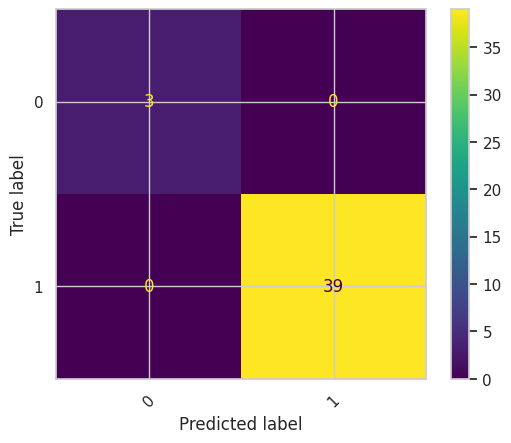

In [ ]:
# Confusion Matrix
cm_lr = confusion_matrix(y_true_labels_lr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp.plot(xticks_rotation=45)
plt.show()